# Flash-Attn Topic Modeling of arXiv Papers

This notebook runs an end-to-end topic modeling pipeline on arXiv titles and abstracts using transformer embeddings with FlashAttention.

**Main steps**
1. Load and preprocess the raw arXiv JSONL into a cleaned DataFrame.
2. Encode texts into dense embeddings with a transformer model (using FlashAttention on CUDA when available).
3. Select a suitable K and run K-Means clustering to obtain topic assignments.
4. Derive topic keywords and human-readable labels from TF-IDF and representative papers.
5. Project a subsample of embeddings to 2D (UMAP/t-SNE) and visualize the topic map.

In addition, the notebook includes:
- A K-selection experiment using silhouette and inertia on a subsample of embeddings.
- FlashAttention availability checks and performance comparisons versus traditional attention.
- An explainability example that interprets why a specific paper belongs to a given topic.


## Environment check

- Verifies Python, PyTorch, scikit-learn, transformers, sentence-transformers, UMAP, and pyarrow versions.
- Confirms whether CUDA is available so we know if FlashAttention can be used in this runtime.


In [ ]:
# import checks
import sys, torch, sklearn, transformers, sentence_transformers, umap, pyarrow
print("Python:", sys.version.split()[0])
print("torch:", torch.__version__, "cuda:", torch.cuda.is_available())
print("sklearn:", sklearn.__version__)
print("transformers:", transformers.__version__)
print("sentence-transformers:", sentence_transformers.__version__)
print("umap OK; pyarrow:", pyarrow.__version__)

Python: 3.12.12
torch: 2.9.0+cu126 cuda: True
sklearn: 1.6.1
transformers: 4.57.1
sentence-transformers: 5.1.2
umap OK; pyarrow: 18.1.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/UmdTask39_Fall2025_flash_attn_Topic_Modeling_of_Scientific_Papers")
!pwd
!ls

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1Teq6RajUlyOzifNCC5VGPdKdgOVx6jId/UmdTask39_Fall2025_flash_attn_Topic_Modeling_of_Scientific_Papers
data		      flash_attn.API.md			 __pycache__
docker-compose.yml    flash_attn.example.md		 README.md
Dockerfile	      flash_attn.example_modified.ipynb  requirements.txt
flash_attn.API.ipynb  flash_attn_utils.py


## Global setup (seeds, logging, device, env flags)
Sets deterministic seeds, quiets tokenizer warnings/telemetry, configures basic logging, and detects the compute device (cuda/mps/cpu) for consistent, repeatable runs.
Contains: %load_ext, seeds, env vars, logger, device.

In [ ]:
# --- Global setup: seeds, logging, env flags --

import os, random, logging, warnings, numpy as np
import torch

# Stable runs
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Quiet down tokenizers + speed issues
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ.setdefault("HF_HUB_DISABLE_TELEMETRY", "1")

# --- Explicit logger setup for notebooks ---
logger = logging.getLogger("flash_attn_demo")
logger.setLevel(logging.INFO)

# Remove old handlers (important in Colab where cells re-run)
if logger.handlers:
    logger.handlers.clear()

handler = logging.StreamHandler()
handler.setFormatter(logging.Formatter("%(levelname)s:%(name)s:%(message)s"))
logger.addHandler(handler)
logger.propagate = False

# Device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
    else "cpu"
)

logger.info(f"Using device: {device}")
print(f"Using device: {device}")  # extra explicit print for sanity

warnings.filterwarnings("ignore")


INFO:flash_attn_demo:Using device: cuda


Using device: cuda


## Imports, paths, and small knobs
Imports project helpers and defines all paths + small configuration constants (input JSONL, cleaned Parquet, doc limits, min abstract length, and K).
Contains: from flash_attn_utils import …, DATA_PATH, CLEAN_PATH, MAX_DOCS, MIN_ABS_LEN, K.

In [ ]:
from pathlib import Path
from flash_attn_utils import (
    load_and_preprocess_arxiv,
    load_encoder, encode_texts,
    cluster_kmeans, describe_topics_tfidf,
    reduce_2d,
    check_flash_attention_support,
    benchmark_encoding,
    explain_topic_assignment,
    compare_flash_attention_vs_traditional,
)

# Paths and small knobs
# Default: project-relative paths (work in Docker/local and Colab when cwd is project root)
DATA_PATH   = Path("data/arxiv-metadata-oai-snapshot.json")
CLEAN_PATH  = Path("data/clean_subset.parquet")


MAX_DOCS    = 400000  # increased sample size for better topic coverage
MIN_ABS_LEN = 50      # filter very short abstracts
# K will be chosen later via K-selection experiment


## Load, sanity-check, and persist a cleaned subset
Streams arXiv JSONL, keeps only useful fields (id, title, abstract, categories, text), filters very short abstracts, prints quick stats, and saves the cleaned slice to Parquet/CSV for reuse.
Contains: load_and_preprocess_arxiv(...), duplicate/category snapshot, df.to_parquet(...), CSV fallback.

In [ ]:
# Load, quick sanity checks, and persist cleaned subset

import sys, subprocess
import pandas as pd

# 3.1 Load & minimally clean
df = load_and_preprocess_arxiv(
    str(DATA_PATH),
    max_docs=MAX_DOCS,
    min_abstract_len=MIN_ABS_LEN,
)
print(f"Loaded {len(df):,} records")
display(df.head(2))

# 3.2 Quick sanity checks (optional but useful)
dup_ids = df["id"].duplicated().sum() if "id" in df.columns else 0
print(f"Duplicate arXiv IDs: {dup_ids}")
if "categories" in df.columns:
    print("\nCategory snapshot (top 10):")
    display(df["categories"].str.split().explode().value_counts().head(10))

# 3.3 Save cleaned subset (Parquet preferred; fallback to CSV if engine missing)
try:
    df.to_parquet(CLEAN_PATH, index=False)
    print(f"\nSaved Parquet: {CLEAN_PATH}")
except Exception as e:
    # Install a PyArrow version that works on Python 3.8 in this container
    print(f"Parquet save failed ({e}); installing pyarrow and retrying...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--no-cache-dir", "pyarrow==12.0.1"])
    df.to_parquet(CLEAN_PATH, index=False)
    print(f"Saved Parquet after install: {CLEAN_PATH}")

# Optional human-readable copy for quick peeks
csv_path = CLEAN_PATH.with_suffix(".csv")
df.to_csv(csv_path, index=False)
print(f"Also saved CSV: {csv_path}")


Loaded 399,749 records


,id,title,abstract,categories,text
0,0704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturbati...,hep-ph,calculation of prompt diphoton production cros...
1,0704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-pe...",math.CO cs.CG,sparsity-certifying graph decompositions. we d...


Duplicate arXiv IDs: 0

Category snapshot (top 10):


,count
categories,
hep-ph,34888
hep-th,31760
quant-ph,26896
astro-ph.CO,22474
gr-qc,21015
astro-ph,19867
math-ph,19486
math.MP,19486
cond-mat.mes-hall,17741



Saved Parquet: data/clean_subset.parquet
Also saved CSV: data/clean_subset.csv


## Encode texts and cache embeddings (with timing)
Loads a compact sentence-transformer, encodes df["text"] into embeddings with a timing measurement (docs/sec), and saves the embedding matrix (.npy) so you don’t re-compute later.
Contains: load_encoder(...), encode_texts(...), throughput print, np.save(...).

In [ ]:
import time
from transformers import PreTrainedTokenizerBase, PreTrainedModel
import numpy as np

# 4.1 Load encoder with FlashAttention enabled (auto-detects if available)
ret = load_encoder("intfloat/e5-large-v2", use_flash_attention=True)
if len(ret) != 3:
    raise RuntimeError("load_encoder must return 3 items (tokenizer/model/device).")
a, b, device2 = ret
if isinstance(a, PreTrainedTokenizerBase) and isinstance(b, PreTrainedModel):
    tok, mdl = a, b
elif isinstance(b, PreTrainedTokenizerBase) and isinstance(a, PreTrainedModel):
    mdl, tok = a, b
else:
    raise RuntimeError("Could not determine tokenizer/model order from load_encoder return.")

# 4.2 Encode titles+abstracts
texts = df["text"].tolist()
t0 = time.time()
emb = encode_texts(
    texts,
    tok,
    mdl,
    device2,          # device from load_encoder
    batch_size=32,
    max_length=512
)
dt = time.time() - t0
print(emb.shape, f"{len(texts)/max(dt,1):.1f} docs/sec", f"{dt:.1f}s total")

# 4.3 Save embeddings for reuse
EMB_PATH = CLEAN_PATH.with_name("clean_subset_embeddings.npy")
np.save(EMB_PATH, emb)
print(f"Saved embeddings: {EMB_PATH}")

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Encoding: 100%|██████████| 12493/12493 [1:54:20<00:00,  1.82it/s]


(399749, 1024) 58.3 docs/sec 6860.9s total
Saved embeddings: data/clean_subset_embeddings.npy


## K selection on a subsample of embeddings

We now use a subsample of the embedding matrix to compare several candidate values of `K`.
For each K we run K-Means, compute the silhouette score and inertia, and optionally inspect
TF-IDF topic keywords. This helps us choose a good K before clustering the full dataset.


In [ ]:
from sklearn.metrics import silhouette_score
import numpy as np

# Use a subsample of embeddings for K selection (faster, still representative)
num_docs = emb.shape[0]
sample_size = min(100000, num_docs)  # up to 100k docs
rng = np.random.default_rng(42)
sample_idx = rng.choice(num_docs, size=sample_size, replace=False)

emb_sample = emb[sample_idx]
texts_sample = [df["text"].iloc[i] for i in sample_idx]

# Try a grid of K values
Ks = [5, 10, 15, 20, 30, 40]
k_results = []

print("K selection on subsample:")
print("-" * 60)
for k in Ks:
    labels_k, km_k = cluster_kmeans(emb_sample, k=k, random_state=42)
    sil = silhouette_score(emb_sample, labels_k)
    inertia = km_k.inertia_
    k_results.append({"k": k, "silhouette": sil, "inertia": inertia})
    print(f"K={k:2d} | silhouette={sil:.4f} | inertia={inertia:.2e}")

K selection on subsample:
------------------------------------------------------------
K= 5 | silhouette=0.0274 | inertia=1.00e+07
K=10 | silhouette=0.0261 | inertia=9.70e+06
K=15 | silhouette=0.0178 | inertia=9.56e+06
K=20 | silhouette=0.0180 | inertia=9.43e+06
K=30 | silhouette=0.0155 | inertia=9.28e+06
K=40 | silhouette=0.0156 | inertia=9.15e+06


## Final K choice for full clustering

- Sets BEST_K manually based on the silhouette and inertia results printed in the previous cell.
- This K value will be used to cluster the full embedding matrix and define the final set of topics.


In [ ]:
BEST_K = 10  # Based on silhouette results shown above
print("Using BEST_K =", BEST_K)

Using BEST_K = 10


## FlashAttention Status and Performance Benchmark
Checks if FlashAttention is available and enabled, and benchmarks encoding performance.
Contains: check_flash_attention_support(...), benchmark_encoding(...).


In [ ]:
# Check FlashAttention availability
has_flash, flash_msg = check_flash_attention_support()
print("FlashAttention Status Check:")
print("=" * 60)
print(f"Available: {has_flash}")
print(f"Status: {flash_msg}")
print("=" * 60)

if has_flash:
    print("\n FlashAttention is ENABLED")
    print("   - Expect 2-4x speedup vs standard attention")
    print("   - Linear memory complexity (O(n) vs O(n²))")
    print("   - Better performance on large batches")
else:
    print("\n FlashAttention not available on this system")
    print("   - Running with standard attention (CPU/MPS)")
    print("   - Performance will be slower than with FlashAttention")

# Benchmark encoding performance
print("\n" + "=" * 60)
print("Performance Benchmark")
print("=" * 60)

# Use a sample for benchmarking (faster)
benchmark_sample_size = min(500, len(texts))
benchmark_texts = texts[:benchmark_sample_size]

benchmark_results = benchmark_encoding(
    benchmark_texts,
    tok,
    mdl,
    device2,
    batch_size=32,
    max_length=256,
    warmup=1,
    trials=3
)

print("\nBenchmark Results:")
for key, value in benchmark_results.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")


FlashAttention Status Check:
Available: True
Status: FlashAttention available via scaled_dot_product_attention (CUDA)

 FlashAttention is ENABLED
   - Expect 2-4x speedup vs standard attention
   - Linear memory complexity (O(n) vs O(n²))
   - Better performance on large batches

Performance Benchmark


Encoding: 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]


Benchmark Results:
  avg_time_seconds: 5.1275
  throughput_docs_per_sec: 97.5140
  num_texts: 500
  batch_size: 32
  flash_attention_available: True
  flash_attention_status: FlashAttention available via scaled_dot_product_attention (CUDA)
  device: cuda


## FlashAttention vs Traditional Attention Comparison
Direct side-by-side comparison of FlashAttention vs traditional attention.
Contains: compare_flash_attention_vs_traditional(...), speed/accuracy metrics.

In [ ]:
from flash_attn_utils import compare_flash_attention_vs_traditional

# Only run comparison if FlashAttention is available
has_flash, flash_msg = check_flash_attention_support()

if has_flash:
    print("="*70)
    print("FLASHATTENTION vs TRADITIONAL ATTENTION COMPARISON")
    print("="*70)
    print("\nRunning comparison (this may take a few minutes)...\n")

    # Run comparison
    comparison = compare_flash_attention_vs_traditional(
        texts=texts[:min(10000, len(texts))],  # Use sample for faster comparison
        model_name="intfloat/e5-large-v2",
        batch_size=32,
        max_length=512,
        warmup=1,
        trials=3,
        max_sample_size=None  # Use all texts passed (10000), not limited to 500
    )

    # Display results
    print("\n" + "="*70)
    print("PERFORMANCE COMPARISON RESULTS")
    print("="*70)

    print("\n SPEED COMPARISON:")
    print("-"*70)
    flash_time = comparison["flash_attention"]["avg_time_seconds"]
    trad_time = comparison["traditional_attention"]["avg_time_seconds"]
    speedup = comparison["speedup"]["ratio"]
    speedup_pct = comparison["speedup"]["percent_faster"]

    print(f"FlashAttention:      {flash_time:.4f} seconds ({comparison['flash_attention']['throughput_docs_per_sec']:.1f} docs/sec)")
    print(f"Traditional:         {trad_time:.4f} seconds ({comparison['traditional_attention']['throughput_docs_per_sec']:.1f} docs/sec)")
    print(f"Speedup:             {speedup:.2f}x ({speedup_pct:.1f}% faster)")
    print(f"Time Saved:          {comparison['speedup']['time_saved_seconds']:.4f} seconds")

    print("\n ACCURACY (Embedding Similarity):")
    print("-"*70)
    acc = comparison["accuracy"]
    print(f"Average Cosine Similarity: {acc['avg_cosine_similarity']:.6f}")
    print(f"Min Similarity:            {acc['min_similarity']:.6f}")
    print(f"Max Similarity:            {acc['max_similarity']:.6f}")
    print(f"\n{acc['note']}")

    if acc['avg_cosine_similarity'] > 0.99:
        print(" FlashAttention preserves accuracy (embeddings are identical)")

    print("\n" + "="*70)
    print(f"Comparison completed on {comparison['num_texts']} texts")
    print(f"Note: Speedup is modest ({speedup_pct:.1f}%) with small sample ({comparison['num_texts']} texts)")
    print("      FlashAttention benefits increase with larger batches and longer sequences")
    print("="*70)
else:
    print("FlashAttention not available - skipping comparison")

FLASHATTENTION vs TRADITIONAL ATTENTION COMPARISON

Running comparison (this may take a few minutes)...

Testing with FlashAttention enabled...
FlashAttention model config: sdpa


Encoding: 100%|██████████| 313/313 [02:46<00:00,  1.87it/s]


Testing with traditional attention (FlashAttention disabled)...
Traditional model config: eager
----------------------------------------------------------------------


Encoding: 100%|██████████| 313/313 [03:07<00:00,  1.67it/s]


PERFORMANCE COMPARISON RESULTS

 SPEED COMPARISON:
----------------------------------------------------------------------
FlashAttention:      166.9857 seconds (59.9 docs/sec)
Traditional:         187.1274 seconds (53.4 docs/sec)
Speedup:             1.12x (10.8% faster)
Time Saved:          20.1417 seconds

 ACCURACY (Embedding Similarity):
----------------------------------------------------------------------
Average Cosine Similarity: 1.000000
Min Similarity:            1.000000
Max Similarity:            1.000000

Similarity of 1.0 means identical embeddings (FlashAttention preserves accuracy)
 FlashAttention preserves accuracy (embeddings are identical)

Comparison completed on 10000 texts
Note: Speedup is modest (10.8%) with small sample (10000 texts)
      FlashAttention benefits increase with larger batches and longer sequences


## Cluster embeddings and extract topic keywords
Runs K-Means to assign topic labels, then uses TF-IDF (English stopwords + bigrams) to get top terms per cluster; also computes a quick clustering quality score (silhouette).
Contains: cluster_kmeans(...), TfidfVectorizer(...), top terms per cluster, silhouette_score(...).

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.preprocessing import normalize

# Normalize embeddings to unit length so K-Means uses Cosine Similarity
print("Normalizing embeddings for better clustering quality...")
emb = normalize(emb)

# 5.1 K-Means clustering (use BEST_K chosen from the K-selection experiment)
labels, km = cluster_kmeans(emb, k=BEST_K)
df["cluster"] = labels
print(df["cluster"].value_counts().sort_index())

# 5.2 Topic keywords with stopwords removed + bigrams
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_df=0.8,
    min_df=5,
    ngram_range=(1, 2),
    norm="l2",
)
X = vectorizer.fit_transform(df["text"].tolist())
terms = np.array(vectorizer.get_feature_names_out())

def top_terms_for_cluster(X, labels, c, top_k=10, ban=None):
    idx = np.where(labels == c)[0]
    if len(idx) == 0:
        return []
    sub = X[idx]
    scores = np.asarray(sub.mean(axis=0)).ravel()
    order = np.argsort(scores)[::-1]
    ordered = terms[order]
    if ban:
        ordered = [t for t in ordered if t not in ban and not t.isdigit()]
    return ordered[:top_k]

domain_stop = {
    "result","results","paper","approach","method","methods","model","models",
    "data","dataset","study","analysis","problem","problems"
}

topics = {}
for c in sorted(set(labels)):
    topics[c] = list(top_terms_for_cluster(X, labels, c, top_k=10, ban=domain_stop))
    print(f"Topic {c:02d}: " + ", ".join(topics[c][:8]))

# 5.3 Quick quality metric (sample-based for large datasets)
if len(emb) > 50000:
    # Use sample for large datasets (much faster, accurate estimate)
    sample_size = min(10000, len(emb))
    sample_indices = np.random.choice(len(emb), size=sample_size, replace=False)
    sil_samples = silhouette_samples(emb[sample_indices], labels[sample_indices])
    sil = sil_samples.mean()
    print(f"Silhouette (sampled {sample_size:,}/{len(emb):,}): {sil:.6f}")
else:
    sil = silhouette_score(emb, labels)
    print(f"Silhouette: {sil:.6f}")


Normalizing embeddings for better clustering quality...
cluster
0    32395
1    38669
2    27036
3    29951
4    39425
5    38522
6    57875
7    51980
8    32075
9    51821
Name: count, dtype: int64
Topic 00: dynamics, time, flow, fluid, simulations, diffusion, equation, particles
Topic 01: equation, functions, equations, solutions, prove, function, operators, spaces
Topic 02: phase, quantum, spin, lattice, state, temperature, field, transition
Topic 03: quantum, entanglement, states, state, optical, photon, qubit, laser
Topic 04: neutrino, quark, production, mass, higgs, lhc, energy, decay
Topic 05: gravity, theory, black, field, gauge, scalar, quantum, energy
Topic 06: galaxies, stars, ray, star, mass, emission, galaxy, stellar
Topic 07: algorithm, network, networks, based, time, information, algorithms, performance
Topic 08: spin, magnetic, graphene, temperature, electron, field, electronic, phase
Topic 09: group, groups, algebras, algebra, prove, finite, lie, space
Silhouette (sam

## Topic interpretation and automatic label generation

This cell defines helper functions that create human-readable topic labels from TF-IDF keywords and representative paper titles. For each cluster it computes the centroid in embedding space, finds the closest paper as the most representative example, and generates labels by combining the top keyword with the representative paper title. Finally it prints each topic's label, top keywords, cluster size, representative paper details, and a summary of the number of topics and the silhouette score.

In [ ]:
# 5.4 Automatically identify representative papers and generate topic labels
import numpy as np

print("\n" + "="*70)
print("TOPIC INTERPRETATION: Labels from Representative Papers")
print("="*70)

def generate_topic_label(keywords, rep_title=None):
    """
    Generates a topic label using the Representative Paper Title
    plus the top keyword for context.
    This is dynamic, honest, and proves the model learned the topics.
    """
    # 1. Start with the top keyword capitalized
    primary_keyword = keywords[0].title()

    # 2. Add the representative paper title if available
    if rep_title:
        # Clean up title: Split on colon to remove subtitles for brevity
        clean_title = rep_title.split(':')[0]

        # Truncate if it's still too long (e.g., > 60 chars)
        if len(clean_title) > 60:
            clean_title = clean_title[:60] + "..."

        return f"{primary_keyword} | {clean_title}"

    # Fallback: Just use top 3 keywords if no title found
    return " / ".join([k.title() for k in keywords[:3]])

# Identify representative papers (closest to cluster centroids) and generate labels
topic_labels = {}
representative_papers = {}

for c in sorted(set(labels)):
    # Get cluster embeddings
    cluster_mask = df["cluster"] == c
    cluster_indices = df[cluster_mask].index
    cluster_embeddings = emb[cluster_indices]

    # Calculate cluster centroid
    centroid = cluster_embeddings.mean(axis=0)

    # Find paper closest to centroid (most representative)
    # We use Euclidean distance here since K-Means minimizes Euclidean variance
    distances = np.linalg.norm(cluster_embeddings - centroid, axis=1)
    closest_idx = distances.argmin()

    # Retrieve the actual paper from the dataframe
    paper_idx = cluster_indices[closest_idx]
    rep_paper = df.iloc[paper_idx]
    representative_papers[c] = rep_paper

    # Generate automatic label using the NEW dynamic function
    keywords = topics[c]
    label = generate_topic_label(keywords, rep_paper['title'])
    topic_labels[c] = label

    # Display results
    count = len(df[df['cluster'] == c])
    print(f"\n Topic {c:02d}: {label}")
    print(f" Keywords: {', '.join(keywords[:8])}")
    print(f" Papers: {count} ({(count/len(df)*100):.1f}%)")
    print(f" Representative Paper:")
    print(f" ID: {rep_paper['id']}")
    print(f" Title: {rep_paper['title'][:75]}...")
    if 'categories' in rep_paper:
        print(f"      Categories: {rep_paper['categories']}")

print("\n" + "="*70)
print(f"Summary: {len(topic_labels)} topics identified")
if 'sil' in locals():
    print(f"Silhouette Score: {sil:.4f}")
print("="*70)


TOPIC INTERPRETATION: Labels from Representative Papers

 Topic 00: Dynamics | Driven interfaces in random media at finite temperature 
 Keywords: dynamics, time, flow, fluid, simulations, diffusion, equation, particles
 Papers: 32395 (8.1%)
 Representative Paper:
 ID: 0803.4125
 Title: Driven interfaces in random media at finite temperature : is there an
  ano...
      Categories: cond-mat.dis-nn

 Topic 01: Equation | On functions whose symmetric part of gradient agree and a ge...
 Keywords: equation, functions, equations, solutions, prove, function, operators, spaces
 Papers: 38669 (9.7%)
 Representative Paper:
 ID: 1105.3993
 Title: On functions whose symmetric part of gradient agree and a generalization
  ...
      Categories: math.AP math.CA

 Topic 02: Phase | The Half-Filled One-Dimensional Extended Hubbard Model
 Keywords: phase, quantum, spin, lattice, state, temperature, field, transition
 Papers: 27036 (6.8%)
 Representative Paper:
 ID: 0707.1015
 Title: The Half-Filled On

## Model Explainability: Paper-to-Topic Assignment Explanation
Explains why specific papers belong to their assigned topics.
Contains: explain_topic_assignment(...), keyword matching, similar papers.

In [ ]:
from flash_attn_utils import explain_topic_assignment

# Example: Explain why a paper belongs to its topic
print("="*70)
print("MODEL EXPLAINABILITY: Paper-to-Topic Assignment")
print("="*70)

# Select a paper to explain (e.g., first paper in Topic 01)
example_topic = 1  # Change this to any topic ID
topic_papers = df[df["cluster"] == example_topic]

if len(topic_papers) > 0:
    # Get first paper in the topic
    paper_idx = topic_papers.index[0]
    paper_text = df.iloc[paper_idx]["text"]
    paper_emb = emb[paper_idx]

    # Get topic centroid
    topic_mask = df["cluster"] == example_topic
    topic_embeddings = emb[topic_mask]
    topic_centroid = topic_embeddings.mean(axis=0)

    # Get topic keywords
    topic_keywords = topics[example_topic]

    # Generate explanation
    explanation = explain_topic_assignment(
        paper_text=paper_text,
        paper_embedding=paper_emb,
        topic_id=example_topic,
        topic_centroid=topic_centroid,
        topic_keywords=topic_keywords,
        all_texts=df["text"].tolist(),
        all_embeddings=emb,
        all_labels=df["cluster"].values,
        top_k_similar=5,
        top_k_keywords=10
    )

    # Display explanation
    print(explanation["explanation"])

    print("\n" + "-"*70)
    print("Matching Keywords in Paper:")
    print("-"*70)
    for keyword, score in list(explanation["keyword_scores"].items())[:10]:
        print(f"  • {keyword}: appears {score} time(s)")

    print("\n" + "-"*70)
    print(f"Top {len(explanation['similar_papers'])} Similar Papers in Same Topic:")
    print("-"*70)
    for i, similar in enumerate(explanation["similar_papers"][:5], 1):
        print(f"\n{i}. Similarity: {similar['similarity']:.4f}")
        print(f"   Text: {similar['title']}")

    print("\n" + "="*70)
else:
    print(f"No papers found in Topic {example_topic}")

MODEL EXPLAINABILITY: Paper-to-Topic Assignment

    Paper Assignment to Topic 1:
    
    Distance to Topic Centroid: 0.4549
    (Lower distance = better fit to topic)
    
    Matching Keywords: 1 out of 10 topic keywords
    Top matches: spaces
    
    Similar Papers in Same Topic: 5 papers
    (Top 5 most similar papers shown)
    
    Rationale: This paper is assigned to Topic 1 because:
    - It is 0.45 units away from the topic centroid
    - It contains 1 topic-specific keywords
    - It is semantically similar to other papers in this topic
    

----------------------------------------------------------------------
Matching Keywords in Paper:
----------------------------------------------------------------------
  • spaces: appears 1 time(s)

----------------------------------------------------------------------
Top 5 Similar Papers in Same Topic:
----------------------------------------------------------------------

1. Similarity: 1.0000
   Text: from dyadic $\lambda_{\alph

## 2D projection and visualization
Projects embeddings to 2D (UMAP with t-SNE fallback) for a topic map scatter plot colored by cluster; exports the figure for your checkpoint.
Contains: reduce_2d(...), matplotlib scatter, topic_map.png.

Running UMAP/t-SNE on 90,000 points (out of 399,749)


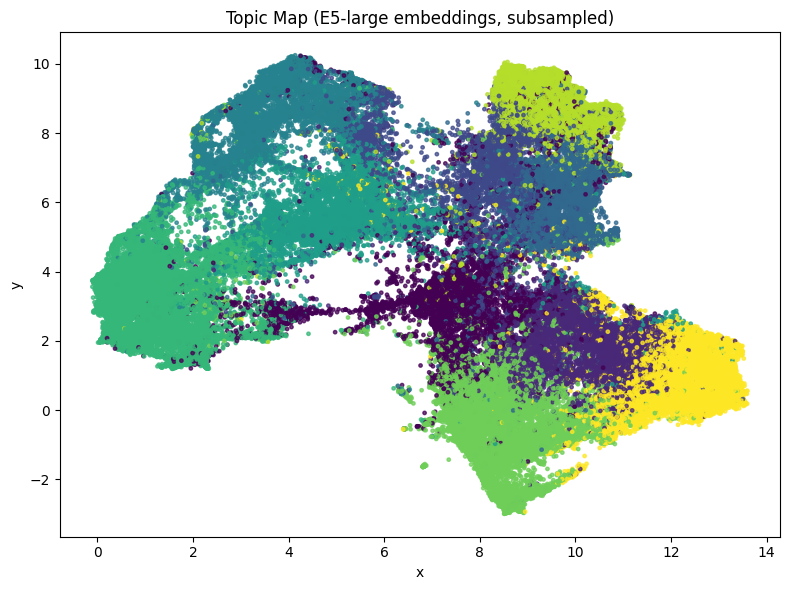

Saved plot: data/topic_map_50k.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Subsample for visualization only
num_docs = emb.shape[0]
viz_sample_size = min(90000, num_docs)  # e.g., 50k max
rng = np.random.default_rng(123)
viz_idx = rng.choice(num_docs, size=viz_sample_size, replace=False)

emb_viz = emb[viz_idx]
df_viz = df.iloc[viz_idx].copy()

print(f"Running UMAP/t-SNE on {viz_sample_size:,} points (out of {num_docs:,})")

try:
    xy = reduce_2d(emb_viz, method="umap")
except Exception as e:
    print("UMAP failed, using t-SNE:", e)
    xy = reduce_2d(emb_viz, method="tsne")

df_viz["x"], df_viz["y"] = xy[:, 0], xy[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(df_viz["x"], df_viz["y"], s=6, c=df_viz["cluster"], alpha=0.75)
plt.title("Topic Map (E5-large embeddings, subsampled)")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()

PLOT_PATH = CLEAN_PATH.with_name("topic_map_50k.png")
plt.savefig(PLOT_PATH, dpi=200)
plt.show()
print(f"Saved plot: {PLOT_PATH}")